In [ ]:
# Enable this cell if using Google Collab:

#!pip install box2d-py
#!pip install gym[Box_2D]

# RESTART RUNTIME AFTER INSTALLING ON GOOGLE COLLAB

### **LunarLander-v2 Continuous (maximum 1000 steps)**
#### Actor-Critic Architecture. The actor is in charge of the policy wheras the critic provides the actor with the state-action values.

#### The input to the network consists of 8 float values that specify the coordinates of the agent, the speed in each direction, the angle...
#### The outputs of the actor are two floats which control the intesity of the main engine (from -1 to 0: the engine is off and from 0 till 1: the power increases) and the relation between left and right engine (near -1: left engine is on and near 1: right engine is on)
##### The output of the actor goes through a tanh activation function that returns values between -1 and 1. The critic gets the state and the action as the input and returns the Q-value without an activation function.
##### **This environment is considered to be solved when getting an average of 200 over 100 consecutive episodes.**

In [1]:
# Imports the libraries:

import random
import numpy as np
from tensorflow import keras
import tensorflow as tf
import gym
env = gym.make('LunarLanderContinuous-v2')

In [2]:
# Creating the actor:

stateInput        = keras.Input(shape = (8,))    

actorDense1       = keras.layers.Dense(units = 128, activation = "relu")   (stateInput)
actorDense2       = keras.layers.Dense(units = 128, activation = "relu")   (actorDense1)
actorDense3       = keras.layers.Dense(units = 32, activation = "relu")    (actorDense2)
actorOutput       = keras.layers.Dense(units = 2, activation = "tanh")     (actorDense3)

actorModel        = keras.Model (inputs = stateInput, outputs = actorOutput)
actorModel.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss ="mse")

#print (actorModel.summary())

# Creating the critic:

stateDense1       = keras.layers.Dense(units = 128, activation="relu")      (stateInput)
stateDense2       = keras.layers.Dense(units = 64, activation="relu")       (stateDense1)
actionInput       = keras.Input(shape = (2,), name="actionInput")                            
actionDense1      = keras.layers.Dense(units = 64, activation="relu")       (actionInput)       

criticConcatenate = keras.layers.Concatenate()                              ([stateDense2, actionDense1])
criticDense1      = keras.layers.Dense(units = 128, activation = "relu")    (criticConcatenate)
criticDense2      = keras.layers.Dense(units = 128, activation = "relu")    (criticDense1)
criticOutput      = keras.layers.Dense(units = 1)                           (criticDense2)

criticModel = keras.Model(inputs = [stateInput, actionInput] , outputs = criticOutput )
criticModel.compile(optimizer = keras.optimizers.Adam(lr=0.001), loss = "mse")


# Creating the target networks for both the actor and the critic:

staticActorModel  = keras.models.clone_model( actorModel, input_tensors=None, clone_function=None)
staticCriticModel = keras.models.clone_model( criticModel, input_tensors=None, clone_function=None)



#print (criticModel.summary())

In [3]:
# Function used to soft update the static Model weights for any given Tau:

def updateStaticWeights(model, staticModel,tau):
    modelWeights = model.get_weights()
    staticWeights = staticModel.get_weights()
    
    #Python broadcasting:
    
    for i in range (len(staticWeights)):
     
        staticWeights[i] = (1-tau) * staticWeights[i] + tau * modelWeights[i]

        
    staticModel.set_weights(staticWeights)


    return model, staticModel

In [4]:
# Memory Replay is carried out in this function.
# 256 random previous experiences are "remembered" and processed in each step with a batch size of 32
# This way we can prevent overfitting most recent states:

def executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryActions, memoryRD, actorModel, staticActorModel, criticModel, staticCriticModel, itemsInMemory):
    randomList = np.random.permutation(itemsInMemory) # After that number everything is 0
    
    memoryPreviousStates = memoryPreviousStates[randomList[:numberOfLearningFromReplaySteps]]
    memoryStates = memoryStates[randomList[:numberOfLearningFromReplaySteps]]
    memoryRD = memoryRD[randomList[:numberOfLearningFromReplaySteps]]
    memoryActions = memoryActions[randomList[:numberOfLearningFromReplaySteps]]

    
    previousState = memoryPreviousStates
    state = memoryStates
    actions = memoryActions
    reward, done = np.split(memoryRD,2,axis=1)
    

    
    # Critic Model Training:
    
    futureActions       = staticActorModel.predict (state)

    valueState          = staticCriticModel.predict ([state, futureActions])

    valuePreviousState = reward + discount * valueState * (1-done) #for those rows in which done is False:

    criticModel.fit ( x = [previousState, actions], y = valuePreviousState, epochs=1, verbose = 0, batch_size =32)


    
    # Actor Model Training:    
    
    with tf.GradientTape() as tape:
        tape.watch(actorModel.trainable_weights)
        
        predictedActions = actorModel(previousState, training=False)
 
        criticPreds = criticModel ([previousState, predictedActions],  training=False)
        
    fromCriticToActorGrads = tape.gradient(criticPreds, actorModel.trainable_weights)
    fromCriticToActorGrads = -np.array(fromCriticToActorGrads) # We are trying to do gradient ascent
    
    gradsAndVariables = zip (fromCriticToActorGrads, actorModel.trainable_weights)
    actorModel.optimizer.apply_gradients(gradsAndVariables)

    


In [5]:
numberEpisodes = 500
discount = 0.99
counter = 0
epsilon = 1
epsilonDecay = 0.995
rewards = []
tau = 0.5
memorySize = 100000
memoryPreviousStates = np.zeros((memorySize,8))
memoryStates = np.zeros((memorySize,8))
memoryActions = np.zeros((memorySize,2))
memoryRD = np.zeros((memorySize,2))
numberOfLearningFromReplaySteps = 256
itemsInMemory = 0
initialiseReplayAfter = 1000 

for episode in range (numberEpisodes):

    epsilon = max (epsilon*epsilonDecay, 0.1)
    done = False
    prevObs = env.reset()
    episodeReward = 0

    for step in range (2000):
        if done:
            break
        #env.render()
        

        if (random.random()<epsilon):
            actions = [random.random()*2-1, random.random()*2-1]
        else:
            actions = actorModel.predict(np.expand_dims(prevObs, axis = 0))[0] # Shape (2,)

        
        obs, reward, done, _ = env.step (actions)


        memoryPreviousStates[counter] = prevObs
        memoryStates[counter] = obs
        memoryActions[counter] = actions
        memoryRD[counter] = [reward, float (done)]

        
        if (counter % 3000 == 0):
            actorModel.save_weights("ACWeights.h5")
            actorModel, staticActorModel   = updateStaticWeights(actorModel, staticActorModel, tau)
            criticModel, staticCriticModel = updateStaticWeights(criticModel, staticCriticModel, tau)
            print ("STATIC WEIGHTS UPDATED")
        
        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter):
            executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryActions, memoryRD, actorModel, staticActorModel, criticModel, staticCriticModel, itemsInMemory)

        prevObs = obs
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    rewards.append(episodeReward)

env.close()
actorModel.save_weights("ACWeights.h5")

STATIC WEIGHTS UPDATED
0  Episode Reward:  -260.87831364163935 .Epsilon: 0.995
1  Episode Reward:  -224.85470477814556 .Epsilon: 0.990025
2  Episode Reward:  -325.16132679957786 .Epsilon: 0.985074875
3  Episode Reward:  3.0691539368713308 .Epsilon: 0.9801495006250001
4  Episode Reward:  -83.92501181423088 .Epsilon: 0.9752487531218751
5  Episode Reward:  -113.99702657990771 .Epsilon: 0.9703725093562657
6  Episode Reward:  -193.2320747910002 .Epsilon: 0.9655206468094844
7  Episode Reward:  -217.52356495469718 .Epsilon: 0.960693043575437
8  Episode Reward:  -389.7050604852948 .Epsilon: 0.9558895783575597
9  Episode Reward:  -314.5162666885744 .Epsilon: 0.9511101304657719
10  Episode Reward:  -396.6471164906467 .Epsilon: 0.946354579813443
11  Episode Reward:  -326.9619693952766 .Epsilon: 0.9416228069143757
12  Episode Reward:  -400.12902921328805 .Epsilon: 0.9369146928798039
13  Episode Reward:  -168.36112452806907 .Epsilon: 0.9322301194154049
14  Episode Reward:  -184.63011420199234 .Epsi

116  Episode Reward:  -285.5348117689465 .Epsilon: 0.5562889678716474
117  Episode Reward:  -177.27503616397703 .Epsilon: 0.5535075230322891
118  Episode Reward:  18.71257058921165 .Epsilon: 0.5507399854171277
119  Episode Reward:  -128.56100826503018 .Epsilon: 0.547986285490042
120  Episode Reward:  -242.1141848818013 .Epsilon: 0.5452463540625918
121  Episode Reward:  -99.30872372371662 .Epsilon: 0.5425201222922789
122  Episode Reward:  -137.20796934332594 .Epsilon: 0.5398075216808175
123  Episode Reward:  -54.939166862473485 .Epsilon: 0.5371084840724134
124  Episode Reward:  -180.43408866972334 .Epsilon: 0.5344229416520513
125  Episode Reward:  -111.47785776323435 .Epsilon: 0.531750826943791
126  Episode Reward:  -252.00305759571256 .Epsilon: 0.5290920728090721
STATIC WEIGHTS UPDATED
127  Episode Reward:  -218.46072154390419 .Epsilon: 0.5264466124450268
128  Episode Reward:  154.4974554561002 .Epsilon: 0.5238143793828016
129  Episode Reward:  -94.10962377898358 .Epsilon: 0.5211953074

225  Episode Reward:  -36.452373386302774 .Epsilon: 0.322118930542046
226  Episode Reward:  -20.773861218455167 .Epsilon: 0.32050833588933575
STATIC WEIGHTS UPDATED
227  Episode Reward:  -86.66863334684936 .Epsilon: 0.31890579420988907
228  Episode Reward:  -34.217850758979594 .Epsilon: 0.3173112652388396
229  Episode Reward:  179.29113417430457 .Epsilon: 0.3157247089126454
STATIC WEIGHTS UPDATED
230  Episode Reward:  -218.4304918135378 .Epsilon: 0.3141460853680822
231  Episode Reward:  -97.67125777174276 .Epsilon: 0.3125753549412418
232  Episode Reward:  -80.26333771080536 .Epsilon: 0.31101247816653554
233  Episode Reward:  -165.04732126896914 .Epsilon: 0.30945741577570285
234  Episode Reward:  -212.8489882847768 .Epsilon: 0.3079101286968243
235  Episode Reward:  -22.214462922350847 .Epsilon: 0.3063705780533402
236  Episode Reward:  93.7201808708315 .Epsilon: 0.30483872516307353
237  Episode Reward:  -150.7237992174229 .Epsilon: 0.3033145315372582
STATIC WEIGHTS UPDATED
238  Episode R

335  Episode Reward:  -395.62010805443805 .Epsilon: 0.18559023879528855
336  Episode Reward:  -156.1179480017826 .Epsilon: 0.1846622876013121
337  Episode Reward:  -46.58373287371969 .Epsilon: 0.18373897616330553
STATIC WEIGHTS UPDATED
338  Episode Reward:  -3.822359025795265 .Epsilon: 0.182820281282489
339  Episode Reward:  -38.16660430832654 .Epsilon: 0.18190617987607657
340  Episode Reward:  -28.271950921118503 .Epsilon: 0.18099664897669618
341  Episode Reward:  233.36467429765045 .Epsilon: 0.1800916657318127
342  Episode Reward:  233.46574337419958 .Epsilon: 0.17919120740315364
343  Episode Reward:  -129.13200218874795 .Epsilon: 0.17829525136613786
344  Episode Reward:  -94.93327492018348 .Epsilon: 0.17740377510930716
STATIC WEIGHTS UPDATED
345  Episode Reward:  231.2478863443314 .Epsilon: 0.17651675623376062
346  Episode Reward:  -104.54851190797027 .Epsilon: 0.1756341724525918
347  Episode Reward:  -99.14193070206741 .Epsilon: 0.17475600159032884
348  Episode Reward:  -98.9100418

448  Episode Reward:  -335.97683809106354 .Epsilon: 0.10533270926593409
449  Episode Reward:  -66.07767724201851 .Epsilon: 0.10480604571960442
450  Episode Reward:  12.600412507384817 .Epsilon: 0.1042820154910064
STATIC WEIGHTS UPDATED
451  Episode Reward:  172.88432325342782 .Epsilon: 0.10376060541355137
452  Episode Reward:  71.5435538300623 .Epsilon: 0.1032418023864836
453  Episode Reward:  217.16681652084887 .Epsilon: 0.10272559337455119
454  Episode Reward:  234.54335113379054 .Epsilon: 0.10221196540767843
455  Episode Reward:  228.49083568265658 .Epsilon: 0.10170090558064004
456  Episode Reward:  -11.281745423731849 .Epsilon: 0.10119240105273684
STATIC WEIGHTS UPDATED
457  Episode Reward:  -289.96157167424036 .Epsilon: 0.10068643904747315
458  Episode Reward:  212.13926345042933 .Epsilon: 0.10018300685223579
459  Episode Reward:  -15.764346572906476 .Epsilon: 0.1
460  Episode Reward:  -79.48731913191435 .Epsilon: 0.1
461  Episode Reward:  -19.053441261225743 .Epsilon: 0.1
462  Ep

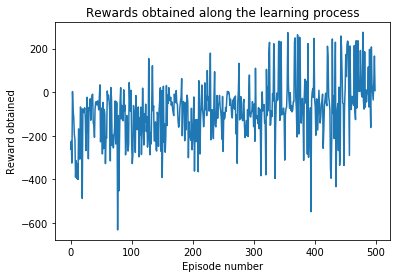

In [7]:
import matplotlib.pyplot as plt
plt.plot (list(range(len(rewards))), rewards)
plt.title("Rewards obtained along the learning process")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.show()

## Let's train the agent for longer:

In [8]:
for episode in range (500, 1000):

    epsilon = max (epsilon*epsilonDecay, 0.1)
    done = False
    prevObs = env.reset()
    episodeReward = 0

    for step in range (2000):
        if done:
            break
        #env.render()
        

        if (random.random()<epsilon):
            actions = [random.random()*2-1, random.random()*2-1]
        else:
            actions = actorModel.predict(np.expand_dims(prevObs, axis = 0))[0] # Shape (2,)

        
        obs, reward, done, _ = env.step (actions)


        memoryPreviousStates[counter] = prevObs
        memoryStates[counter] = obs
        memoryActions[counter] = actions
        memoryRD[counter] = [reward, float (done)]

        
        if (counter % 3000 == 0):
            actorModel.save_weights("ACWeights.h5")
            actorModel, staticActorModel   = updateStaticWeights(actorModel, staticActorModel, tau)
            criticModel, staticCriticModel = updateStaticWeights(criticModel, staticCriticModel, tau)
            print ("STATIC WEIGHTS UPDATED")
        
        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter):
            executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryActions, memoryRD, actorModel, staticActorModel, criticModel, staticCriticModel, itemsInMemory)

        prevObs = obs
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    rewards.append(episodeReward)

env.close()
actorModel.save_weights("ACWeights.h5")

500  Episode Reward:  220.82212084785942 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
501  Episode Reward:  23.433244226053873 .Epsilon: 0.1
502  Episode Reward:  15.19106441873096 .Epsilon: 0.1
503  Episode Reward:  9.272180270211422 .Epsilon: 0.1
504  Episode Reward:  263.82156464350896 .Epsilon: 0.1
505  Episode Reward:  199.4385284896282 .Epsilon: 0.1
506  Episode Reward:  -2.815508908460785 .Epsilon: 0.1
507  Episode Reward:  -147.63398892994434 .Epsilon: 0.1
508  Episode Reward:  -38.606133024529946 .Epsilon: 0.1
509  Episode Reward:  -38.23941677929537 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
510  Episode Reward:  4.3450222458047705 .Epsilon: 0.1
511  Episode Reward:  13.494123868959164 .Epsilon: 0.1
512  Episode Reward:  -54.65489627153236 .Epsilon: 0.1
513  Episode Reward:  -56.930707321852964 .Epsilon: 0.1
514  Episode Reward:  253.72946377426908 .Epsilon: 0.1
515  Episode Reward:  -18.532616382574844 .Epsilon: 0.1
516  Episode Reward:  278.7822976942335 .Epsilon: 0.1
517  Episode Reward

645  Episode Reward:  84.98654563242562 .Epsilon: 0.1
646  Episode Reward:  250.25204627433502 .Epsilon: 0.1
647  Episode Reward:  228.36640311492965 .Epsilon: 0.1
648  Episode Reward:  8.726860884097078 .Epsilon: 0.1
649  Episode Reward:  -36.82865504137557 .Epsilon: 0.1
650  Episode Reward:  4.252689864397112 .Epsilon: 0.1
651  Episode Reward:  277.8296928345976 .Epsilon: 0.1
652  Episode Reward:  -1.9809180688664014 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
653  Episode Reward:  -58.10499494032992 .Epsilon: 0.1
654  Episode Reward:  191.00899380189514 .Epsilon: 0.1
655  Episode Reward:  267.2109789320141 .Epsilon: 0.1
656  Episode Reward:  -21.854322244087626 .Epsilon: 0.1
657  Episode Reward:  -19.387618779964683 .Epsilon: 0.1
658  Episode Reward:  14.20253379091234 .Epsilon: 0.1
659  Episode Reward:  238.5744548510841 .Epsilon: 0.1
660  Episode Reward:  -2.2612308459861197 .Epsilon: 0.1
661  Episode Reward:  239.4680894541447 .Epsilon: 0.1
662  Episode Reward:  302.2096048867712 .Epsil

788  Episode Reward:  -92.50678868819782 .Epsilon: 0.1
789  Episode Reward:  61.25337162862664 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
790  Episode Reward:  -313.75560897014896 .Epsilon: 0.1
791  Episode Reward:  -72.08371011120207 .Epsilon: 0.1
792  Episode Reward:  224.7677260011943 .Epsilon: 0.1
793  Episode Reward:  -17.537809687530597 .Epsilon: 0.1
794  Episode Reward:  -104.9517205308236 .Epsilon: 0.1
795  Episode Reward:  258.92380162617496 .Epsilon: 0.1
796  Episode Reward:  48.045955145372034 .Epsilon: 0.1
797  Episode Reward:  20.342048164019133 .Epsilon: 0.1
798  Episode Reward:  17.3698996646704 .Epsilon: 0.1
799  Episode Reward:  -234.10016948089873 .Epsilon: 0.1
800  Episode Reward:  -169.70994039570073 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
801  Episode Reward:  1.3468104338724487 .Epsilon: 0.1
802  Episode Reward:  275.1364135726262 .Epsilon: 0.1
803  Episode Reward:  30.961531919747642 .Epsilon: 0.1
804  Episode Reward:  201.1281715258213 .Epsilon: 0.1
805  Episode Reward: 

931  Episode Reward:  -36.12114672571105 .Epsilon: 0.1
932  Episode Reward:  -4.8915246220790465 .Epsilon: 0.1
933  Episode Reward:  12.375639632267124 .Epsilon: 0.1
934  Episode Reward:  9.336830815532338 .Epsilon: 0.1
935  Episode Reward:  38.30957944977675 .Epsilon: 0.1
936  Episode Reward:  261.39310477146626 .Epsilon: 0.1
937  Episode Reward:  11.14152146083292 .Epsilon: 0.1
938  Episode Reward:  -160.02410306858786 .Epsilon: 0.1
939  Episode Reward:  -69.75553802289357 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
940  Episode Reward:  232.56362381196584 .Epsilon: 0.1
941  Episode Reward:  -49.2244858353978 .Epsilon: 0.1
942  Episode Reward:  -6.121159983346491 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
943  Episode Reward:  -21.102391302166712 .Epsilon: 0.1
944  Episode Reward:  287.17752727887705 .Epsilon: 0.1
945  Episode Reward:  14.932266486467313 .Epsilon: 0.1
946  Episode Reward:  252.37150507047278 .Epsilon: 0.1
947  Episode Reward:  -18.115017281896467 .Epsilon: 0.1
948  Episode Reward

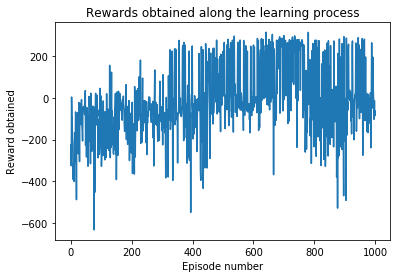

In [9]:
plt.plot (list(range(len(rewards))), rewards)
plt.title("Rewards obtained along the learning process")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.show()

### It seems like the agent was learning till the episode number 700-750 after which it started being more unstable. Let's see how it behaves after 1000 episodes:

In [11]:
# Testing loop (Google colab cannot render the environment, only computations can be done. Render in Local Machine!)

numberOfTestingEpisodes = 100
testingRewards = []
for episode in range (numberOfTestingEpisodes):
    done = False
    episodeReward = 0
    prevObs = env.reset()
    for step in range (1010):
       
        if done:
            break
        #env.render()
        
       

        actions = actorModel.predict(np.expand_dims(prevObs, axis = 0))[0] # Shape (2,)
        
        
        obs, reward, done, info = env.step (actions)
        
        prevObs = obs
        episodeReward += reward
      
    print (episode, " Episode Reward: ", episodeReward)
    testingRewards.append(episodeReward)
env.close()

0  Episode Reward:  -141.73831187858465
1  Episode Reward:  16.444819945082827
2  Episode Reward:  -99.00878881743233
3  Episode Reward:  -79.5641804614252
4  Episode Reward:  -116.87796199820517
5  Episode Reward:  -111.48274261304185
6  Episode Reward:  -107.19208756826605
7  Episode Reward:  -104.31122730204464
8  Episode Reward:  -96.21781593522245
9  Episode Reward:  185.43544132550164
10  Episode Reward:  -33.26735269952488
11  Episode Reward:  -35.08828632123557
12  Episode Reward:  -90.09567623089464
13  Episode Reward:  -70.39016928375659
14  Episode Reward:  229.78536873641127
15  Episode Reward:  -80.80289663724385
16  Episode Reward:  -171.26420070479548
17  Episode Reward:  -125.03273556748276
18  Episode Reward:  276.3827482785854
19  Episode Reward:  -101.99332030594735
20  Episode Reward:  -101.18251923685455
21  Episode Reward:  266.2614461213449
22  Episode Reward:  53.06938313652111
23  Episode Reward:  -116.37385756593895
24  Episode Reward:  42.329400075738505
25  

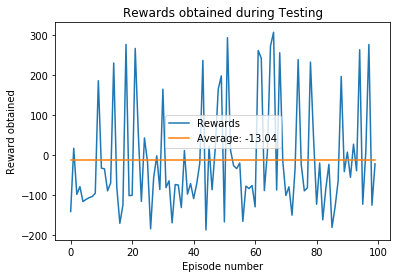

In [12]:
plt.plot (list(range(len(testingRewards))), testingRewards)
plt.plot (list(range(len(testingRewards))), [np.average(testingRewards)]*len(testingRewards))
plt.title("Rewards obtained during Testing")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.legend(["Rewards", "Average: %.2f" % np.average(testingRewards)])
plt.show()

## The agent is unstable and even though it gets more than 200 points quite frequently, it has forgotten how to avoid crashing by flying slower. Let's check some previously saved versions to see if it had previously learnt a better policy:

In [15]:
# Testing loop (Google colab cannot render the environment, only computations can be done. Render in Local Machine!)

actorModel.load_weights("lunarLanderContinuous750episodes.h5")
numberOfTestingEpisodes = 100
testingRewards = []
for episode in range (numberOfTestingEpisodes):
    done = False
    episodeReward = 0
    prevObs = env.reset()
    for step in range (1010):
       
        if done:
            break
        env.render()
        
       

        actions = actorModel.predict(np.expand_dims(prevObs, axis = 0))[0] # Shape (2,)
        
        
        obs, reward, done, info = env.step (actions)
        
        prevObs = obs
        episodeReward += reward
      
    print (episode, " Episode Reward: ", episodeReward)
    testingRewards.append(episodeReward)
env.close()

0  Episode Reward:  273.30187807370305
1  Episode Reward:  254.67306635376053
2  Episode Reward:  280.7085340431548
3  Episode Reward:  223.2921579611775
4  Episode Reward:  202.75277368891375
5  Episode Reward:  233.7991162407378
6  Episode Reward:  256.7787144919349
7  Episode Reward:  254.23973308235858
8  Episode Reward:  254.41627880257835
9  Episode Reward:  286.58973654677203
10  Episode Reward:  261.8912812160525
11  Episode Reward:  287.1453423954157
12  Episode Reward:  10.230226382820504
13  Episode Reward:  228.15683166144134
14  Episode Reward:  218.1877652345555
15  Episode Reward:  230.99339214509615
16  Episode Reward:  45.845812255061816
17  Episode Reward:  -120.1616984214564
18  Episode Reward:  286.87189579666943
19  Episode Reward:  279.78275689807447
20  Episode Reward:  274.41748114262725
21  Episode Reward:  252.23241223609563
22  Episode Reward:  33.54671024592798
23  Episode Reward:  288.0247372887902
24  Episode Reward:  268.05325554366675
25  Episode Reward:

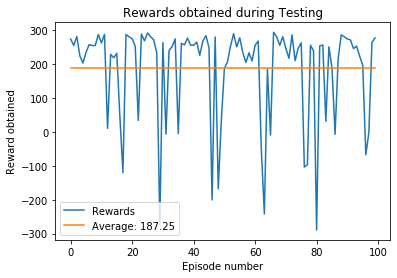

In [16]:
plt.plot (list(range(len(testingRewards))), testingRewards)
plt.plot (list(range(len(testingRewards))), [np.average(testingRewards)]*len(testingRewards))
plt.title("Rewards obtained during Testing")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.legend(["Rewards", "Average: %.2f" % np.average(testingRewards)])
plt.show()

In [17]:
# Testing loop (Google colab cannot render the environment, only computations can be done. Render in Local Machine!)

actorModel.load_weights("lunarLanderContinuous700episodes.h5")
numberOfTestingEpisodes = 100
testingRewards = []
for episode in range (numberOfTestingEpisodes):
    done = False
    episodeReward = 0
    prevObs = env.reset()
    for step in range (1010):
       
        if done:
            break
        env.render()
        
       

        actions = actorModel.predict(np.expand_dims(prevObs, axis = 0))[0] # Shape (2,)
        
        
        obs, reward, done, info = env.step (actions)
        
        prevObs = obs
        episodeReward += reward
      
    print (episode, " Episode Reward: ", episodeReward)
    testingRewards.append(episodeReward)
env.close()

0  Episode Reward:  245.24740378292339
1  Episode Reward:  245.87810222551025
2  Episode Reward:  223.15829970093694
3  Episode Reward:  288.9930288933916
4  Episode Reward:  263.3465753167518
5  Episode Reward:  232.61219742090373
6  Episode Reward:  244.62361292725333
7  Episode Reward:  285.2174105880822
8  Episode Reward:  232.10638155301945
9  Episode Reward:  295.82746209231664
10  Episode Reward:  263.6805047395683
11  Episode Reward:  271.52296585203993
12  Episode Reward:  -8.0663093325293
13  Episode Reward:  280.69305573932047
14  Episode Reward:  233.35048552375486
15  Episode Reward:  -43.294733190986356
16  Episode Reward:  273.1560924084511
17  Episode Reward:  254.80690882043453
18  Episode Reward:  -17.512308004339346
19  Episode Reward:  202.76931849970447
20  Episode Reward:  22.549821086133065
21  Episode Reward:  275.29508191912646
22  Episode Reward:  278.33426747186843
23  Episode Reward:  275.1298326752816
24  Episode Reward:  157.21157804186953
25  Episode Rewa

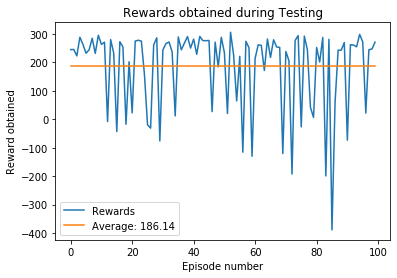

In [18]:
plt.plot (list(range(len(testingRewards))), testingRewards)
plt.plot (list(range(len(testingRewards))), [np.average(testingRewards)]*len(testingRewards))
plt.title("Rewards obtained during Testing")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.legend(["Rewards", "Average: %.2f" % np.average(testingRewards)])
plt.show()

## Both these versions achieve an average really close to 200.0 points over 100 consecutive episodes and therefore, this environment can be considered solved!